# School inspection reports' analysis

This code, which uses SoS as the background, is written in Python (for the data extraction and manipulation) and R (for the Topic analysis). The respective sections can be extracted and used separetely, or jointly by following the installation guidelines presented in the link below.

https://vatlab.github.io/sos-docs/running.html#Local-installation

The user should run the following lines from the Command Prompt

- pip install sos-notebook
- pip install sos-papermill
- pip install sos-r
- python -m sos_notebook.install
- jupyter kernelspec list

and choose SoS as the kernel for a new notebook. Please refer to Notebook Interface of the SoS documentation for details (https://vatlab.github.io/sos-docs/doc/documentation/Notebook_Interface.html)

Data from Ireland taken from https://data.gov.ie/dataset/primary-schools and https://www.education.ie/en/Publications/Inspection-Reports-Publications/Whole-School-Evaluation-Reports-List


# Adding the data to Google Drive.
You can first download the data. Then you have to add them to your Google Drive in a folder and run the following code in the notebook.:

from google.colab import drive
drive.mount('/content/drive/')
The previous code will ask you to go to a given webpage where you copy the link and past it in the Colab form that will appear. Do so to load the data on Google Colab.

Share the same data folder within a team, and be sure that everyone has the same at any time, even though someone changes it. The drawback is that Google Collab has now access to your Google Folder, which you might not be in favor of, depending on your sensibility.

In [ ]:
!pip install sos-notebook
!pip install sos-papermill
!pip install sos-r
!python -m sos_notebook.install
!jupyter kernelspec list

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pwd

/content


In [8]:
!echo /drive/MyDrive/IIPE/data/

/drive/MyDrive/IIPE/data/


In [ ]:
!pip install rpy2
!pip install wget
!pip install pdfminer.six
!pip install geopandas
!pip install geopy
!pip install bs4
!pip install pandas

In [12]:
# We import the necessary packages
import sys, os, csv, requests, re, bs4, datetime, time, threading, wget, pdfminer, geopandas, geopy
import pandas as pd
import matplotlib.pyplot as plt
from pdfminer.high_level import extract_text
from geopy.geocoders import Nominatim
import numpy as np

Select the appropriate working directory

In [19]:
os.chdir('/content/drive/MyDrive/IIPE/data/')

In [20]:
os.getcwd()

'/content/drive/MyDrive/IIPE/data'

In [21]:
if os.getcwd()!="/content/drive/MyDrive/IIPE/data":
    print("Please insert the WORKING DIRECTORY")                                                            # We create a loop so that the user establishes the working directory
    print("Remember to separate the backslash (for Windows) or forward slash (in Mac)") 
    while True:                                                                             
        NewPath=input()                                                                                     # The user inserts the working directory
        if os.path.exists(NewPath)==True:                                                                   # If the program exists, the working directory will be updated
            os.chdir(NewPath)                                                               
            print("Your new path is " + os.getcwd())                                        
            break                                                                                           # If the condition is met, the program keeps running
        else:                                                                                               # If the condition is not met, the program requests the user to
            print("Please check if the path is correctly written")                                          # insert a new path and the condition is checked again
        continue
else: 
    print("Your path is " + os.getcwd())

Your path is /content/drive/MyDrive/IIPE/data


## Extracting the tables from the webpage and turning them into a DataFrame

Note that his DataFrame will not only work to later download the corresponding reports, but it is a useful Metadata database, which can be then used to make analyses on the different results across time, location, or type of school. 

If the error below occur, run `pip install lxml`

_FeatureNotFound: Couldn't find a tree builder with the features you requested: lxml. Do you need to install a parser library?_

In [23]:
!pip install lxml

In [24]:
WebpageRoot = "https://www.education.ie/en/Publications/Inspection-Reports-Publications/Whole-School-Evaluation-Reports-List/?pageNumber="
General_InspectionReports = pd.DataFrame(columns=['Date','School Roll No.','County','School Name','School Level','Inspection Type','Subject','URL'])

# Records:    1 to   20 of 3871
# Records:                             3861 to 3871 of 3871
# Pages:     1|    |     |     |     |   194 |
print("How many pages would you like to download?")

NumberPages = input()

for x in range(1,int(NumberPages)):
    IrelandWebpage = requests.get(WebpageRoot + str(x))
    CleanIrelandWebpage = bs4.BeautifulSoup(IrelandWebpage.text, "lxml")
    InspectionReports = {}
    ID = 0
    Table = CleanIrelandWebpage.find('table', id="IRList")
    for p in Table.find_all('tr'):
        if ID == 0:
            ID = ID + 1
            continue
        else:
            Date = p('td')[0].string[:2] + '_' + p('td')[0].string[3:5] + '_' + p('td')[0].string[6:]
            SchoolRoll = p('td')[1].string
            County = p('td')[2].string
            SchoolName = p('td')[3].string
            SchoolLevel = p('td')[4].string
            InspectionType = p('td')[5].string
            Subject = p('td')[6].string
            URL = p('td')[7]('a')[0].attrs['href'][86:]
            InspectionReports[ID] = {'Date': Date, 'School Roll No.': SchoolRoll, 'County': County, 'School Name': SchoolName, 'School Level': SchoolLevel, 'Inspection Type': InspectionType, 'Subject': Subject, 'URL': URL}
            ID = ID + 1

    df_InspectionReports = pd.DataFrame.from_dict(InspectionReports, orient='index')
    General_InspectionReports = pd.concat([General_InspectionReports,df_InspectionReports]) 


How many pages would you like to download?
10


In [27]:
pd.concat([df_InspectionReports.head(3), df_InspectionReports.tail(3)])

,Date,School Roll No.,County,School Name,School Level,Inspection Type,Subject,URL
1,18_06_2019,15496Q,Sligo,Leaffoney N S Leaffoney Kilglass Sligo,Primary,Whole School Evaluation,None,15496Q_WSEMLLP_10042_20190313.pdf
2,18_06_2019,17313P,Cork,"Our Lady Of Lourdes, Ballinlough Road, Cork",Primary,Whole School Evaluation,None,17313P_WSEMLLP_9555_20190405.pdf
3,18_06_2019,18044T,Meath,S N Naomh Padraig Cockhill Road Stamullen Meath,Primary,Whole School Evaluation,None,18044T_WSEMLLP_9482_20190412.pdf
18,30_05_2019,17799V,Tipperary N.R.,S N Na hAille Aill An Mhóin Ard Tipperary,Primary,Whole School Evaluation,None,17799V_WSEMLLP_9627_20190313.pdf
19,30_05_2019,91396R,Cork,"Douglas Community School, Clermont Avenue, Dou...",Post Primary,Whole School Evaluation,None,91396R_WSEMLLPP_9792_20190222.pdf
20,29_05_2019,19837N,Dublin,Drimnagh Castle Cbs N S Drimnagh Castle Long M...,Primary,Whole School Evaluation,None,19837N_WSEMLLP_9455_20190307.pdf


In [28]:
pd.concat([General_InspectionReports.head(3), General_InspectionReports.tail(3)])

,Date,School Roll No.,County,School Name,School Level,Inspection Type,Subject,URL
1,27_01_2021,70660O,Kildare,Curragh Post-Primary School Mcswiney Road Curr...,Post Primary,Whole School Evaluation,None,70660O_WSEMLLPP_14538_20200207.pdf
2,26_01_2021,61811I,Wicklow,St. Gerard's School Thornhill Road Bray Wicklow,Post Primary,Whole School Evaluation,None,61811I_WSEMLLPP_14721_20200331.pdf
3,15_01_2021,62360G,Cork,Christian Brothers Secondary School Castleredm...,Post Primary,Whole School Evaluation,None,62360G_WSEMLLPP_15122_20201109.pdf
18,30_05_2019,17799V,Tipperary N.R.,S N Na hAille Aill An Mhóin Ard Tipperary,Primary,Whole School Evaluation,None,17799V_WSEMLLP_9627_20190313.pdf
19,30_05_2019,91396R,Cork,"Douglas Community School, Clermont Avenue, Dou...",Post Primary,Whole School Evaluation,None,91396R_WSEMLLPP_9792_20190222.pdf
20,29_05_2019,19837N,Dublin,Drimnagh Castle Cbs N S Drimnagh Castle Long M...,Primary,Whole School Evaluation,None,19837N_WSEMLLP_9455_20190307.pdf


## Downloading the PDFs

In [ ]:
PDFToConvert = []
for index, row in General_InspectionReports.iterrows():
    DownloadURL = 'https://www.education.ie/en/Publications/Inspection-Reports-Publications/Whole-School-Evaluation-Reports-List/' + row['URL']
    FileName = 'Reports\\' + row['School Roll No.'] + '_' + row['Date'] + '.pdf'
    PDFToConvert.append('Reports\\' + row['School Roll No.'] + '_' + row['Date'])
    print('Report ' + row['School Roll No.'] + ' downloaded')
    wget.download(DownloadURL, FileName)

## Converting the PDFs to text and cleaning them from unusefull content

In [ ]:
ConvertionCategories = {"Properly processed":0, "Not in text format":0, "Cannot be processed":0}
FilesProperlyConverted = {}
FilesNotConverted = []
def find_2nd(string, substring):
    return string.find(substring, string.find(substring) + 1)
for PDF in PDFToConvert:
    try: 
        Text = extract_text(PDF + '.pdf')
        if len(Text)==0:
            ConvertionCategories["Not in text format"] = ConvertionCategories["Not in text format"] + 1
            print(PDF + ' is not in text format')
        else:
            ConvertionCategories["Properly processed"] = ConvertionCategories["Properly processed"] + 1
            Option1 = Text.find('WHOLE-SCHOOL EVALUATION – MANAGEMENT, LEADERSHIP AND LEARNING   Dates of inspection')
            if Option1 != -1:
                Text = Text[Option1:]
            Option2 = Text.find('WHOLE-SCHOOL EVALUATION – MANAGEMENT, LEADERSHIP AND LEARNING    Date of inspection')
            if Option2 != -1:
                Text = Text[Option2:]
            Option3 = Text.find('WHOLE-SCHOOL EVALUATION – MANAGEMENT, LEADERSHIP AND LEARNING  Dates of inspection')
            if Option3 != -1:
                Text = Text[Option3:]
            Option4 = Text.find('WHOLE-SCHOOL EVALUATION – MANAGEMENT, LEADERSHIP AND LEARNING Dates of inspection')
            if Option4 != -1:
                Text = Text[Option4:]
            Option5 = Text.find('Whole-School Evaluation – Management, Leadership and Learning Dates of inspection')
            if Option5 != -1:
                Text = Text[Option5:]
            Option6 = Text.find('Whole-School Evaluation Date of inspection')
            if Option6 != -1:
                Text = Text[Option6:]
            if Text.find('An Roinn') == 1:
                Text = Text[find_2nd(Text, 'Dates of inspection'):]
            Option7 = Text.find('THE INSPECTORATE’S QUALITY CONTINUUM')
            if Option7 != -1:
                Text = Text[:Option7 - 1]
            Option8 = Text.find('MEASTÓIREACHT SCOILE UILE – BAINISTÍOCHT, CEANNAIREACHT AGUS FOGHLAIM')
            if Option8 != -1:
                FilesNotConverted.append(PDF[8:])
                print('Report ' + PDF[8:] + ' could not be processed')
                continue
            FilesProperlyConverted[PDF] = {'Text': Text}
            with open("Reports\\Plain text\\" + PDF[8:] + ".txt", "w", errors="ignore") as output:
                output.write(str(Text))
            print('Report ' + PDF[8:] + ' properly processed')
    except (KeyError, UnicodeEncodeError):
        ConvertionCategories["Cannot be processed"] = ConvertionCategories["Cannot be processed"] + 1
        FilesNotConverted.append(PDF[8:])
        print('Report ' + PDF[8:] + ' could not be processed')
        continue

df_FilesProperlyConverted = pd.DataFrame.from_dict(FilesProperlyConverted, orient='index')

plt.bar(*zip(*ConvertionCategories.items()))
#plt.show()

General_InspectionReports['Key'] = General_InspectionReports['School Roll No.'] + '_' + General_InspectionReports['Date']
General_InspectionReports.to_csv(r'Reports\\InspectionReports.csv', index=False)
for p in range(len(FilesNotConverted)):
    General_InspectionReports.drop(General_InspectionReports[General_InspectionReports.Key == FilesNotConverted[p]].index, inplace=True)
General_InspectionReports.to_csv(r'Reports\\InspectionReports2.csv', index=False)

In [50]:
df_FilesProperlyConverted.head()

,Text
Reports\01300Q_08_10_2020,"Whole-School Evaluation – Management, Leadersh..."
Reports\03220F_15_11_2019,"Whole-School Evaluation – Management, Leadersh..."
Reports\03917V_23_09_2020,"Whole-School Evaluation – Management, Leadersh..."
Reports\05933G_08_10_2020,"Whole-School Evaluation – Management, Leadersh..."
Reports\07518E_15_12_2020,"Whole-School Evaluation – Management, Leadersh..."


In [49]:
df_FilesProperlyConverted.head().Text[0]

'Whole-School Evaluation – Management, Leadership and Learning Dates of inspection  11-02-2020 Inspection activities undertaken \uf0b7 Meetings with principal and in-school leadership team  \uf0b7 Meeting with representatives of the board of management \uf0b7 Meeting with parent representatives \uf0b7 Review of relevant documents   \uf0b7 Analysis of parent and pupil questionnaires \uf0b7 Observation of teaching and learning  \uf0b7 Examination of pupils’ work  \uf0b7 Interaction with pupils  \uf0b7 Feedback to principal, deputy principal and teachers, and to parent and board of management representatives  SCHOOL CONTEXT St Michael’s National School is a rural school located in the village of Danesfort, Co. Kilkenny and operates under the patronage of the Catholic Bishop of Ossory. It has two mainstream class teachers and one special education teacher, shared with another school. Attendance rates of the forty six pupils enrolled are very good.  SUMMARY OF MAIN FINDINGS AND RECOMMENDATI

### Most used words


In [33]:
!pip install nltk

In [39]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

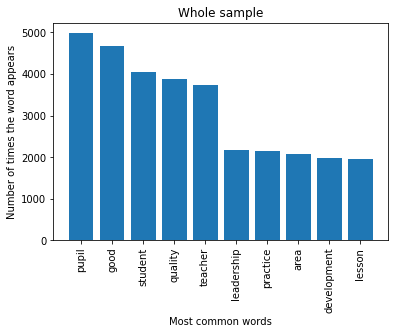

In [40]:
import matplotlib.pyplot as plt
import nltk, re
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
stopwords = set(nltk.corpus.stopwords.words('english'))

TotalText = []
for index, row in df_FilesProperlyConverted.iterrows():
    text = row['Text']
    TotalText.append(text)

newStopWords = ['school','learning','student','pupil','teacher','management','teaching','support', 'lesson', 'board']
stopwords = stopwords.union(newStopWords)
TotalText = " ".join(TotalText)
tokens = [w for w in word_tokenize(TotalText.lower()) if w.isalpha()]          # isalpha() checks if each word is alphabetical, lower() transforms everything to lowercase
no_stop = [t.strip() for t in tokens if t.strip() not in stopwords]      # stopwords already comes with a built-in list of words to remove
wordnet_lemmatizer = WordNetLemmatizer()
lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in no_stop]
bow = Counter(lemmatized)
MostCommon = dict(bow.most_common(10))

plt.bar(*zip(*MostCommon.items()))
plt.title('Whole sample')
plt.xlabel('Most common words')
plt.ylabel('Number of times the word appears')
plt.xticks(rotation='vertical')
plt.savefig("Results\\Word count\\Whole sample.png")
plt.show()


## Topic modelling

The part below is in R, this is why there is a specific kernel in the specs

In [44]:
install.packages("readtext")
install.packages("stm")
install.packages("tm")
install.packages("SnowballC")
install.packages("igraph")

library(readtext)
library(stm)
library(tm)

NameError: ignored

In [ ]:
setwd("C:\\Users\\g.vargas\\BOX\\IIEP_MyProjects\\MP_01000298\\WorkFiles_Inspection\\Ireland")
DATA_DIR <- system.file("extdata/", package = "readtext")
ourdata<-readtext("Reports\\Plain text\\*")
# Import additional metadata (year, language, etc.)
metadata <-read.csv("Reports\\InspectionReports.csv")

In [ ]:
# Stemming and tokenization
NewStopWords <- c('school','learning','student','pupil', 'pupils','teacher','management','teaching','support', 'lesson', 'board')
processed_data <- textProcessor(ourdata$text,  customstopwords=NewStopWords)

# Prepare Documents For Analysis With Stm
prepared_data <- prepDocuments(processed_data$documents, processed_data$vocab, processed_data$meta)
# Once the prepared_data is ready, open it, see where the metadata is located, and add the information from the ourmetadata

In [ ]:
# STM MODELING
# The number of topics can be automatically determined using searchK (see https://cbail.github.io/SICSS_Topic_Modeling.html)
# max.em.its is how many times the model should run
poliblogPrevFit <- stm(prepared_data$documents, prepared_data$vocab, K=3, max.em.its=30, 
                       data=prepared_data$meta, init.type="Spectral")

In [ ]:
png(filename="Results\\Topic modelling\\Two topics word comparison.png", 
    type="cairo",
    units="in", 
    width=10, 
    height=8, 
    pointsize=12, 
    res=300)
plot(poliblogPrevFit, type="perspectives", topics=c(1,2))
dev.off()

In [ ]:
png(filename="Results\\Topic modelling\\Topic prevalence.png", 
    type="cairo",
    units="in", 
    width=10, 
    height=8, 
    pointsize=12, 
    res=300)
plot(poliblogPrevFit, type="summary", xlim=c(0,.8))
dev.off()

In [ ]:
png(filename="Results\\Topic modelling\\Words from selected topics.png", 
    type="cairo",
    units="in", 
    width=10, 
    height=8, 
    pointsize=12, 
    res=300)
plot(poliblogPrevFit, type="labels", topics=c(1,2,3))
dev.off()

In [ ]:
png(filename="Results\\Topic modelling\\Distribution Document Topic Proportions.png", 
    type="cairo",
    units="in", 
    width=10, 
    height=8, 
    pointsize=12, 
    res=300)
plot(poliblogPrevFit, type="hist")
dev.off()

In [ ]:
topic_correlation <- topicCorr(poliblogPrevFit, method = c("simple", "huge"), cutoff = 0.01,
                               verbose = TRUE)

plot(topic_correlation, topics = NULL, vlabels = NULL, layout = NULL,
     vertex.color = "green", vertex.label.cex = 0.75,
     vertex.label.color = "black")